In [1]:
import importlib
import pyspark.sql.functions as F
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import pacf

import data_loader
import data_downloader
import autocorrelation_calculator
import utils
import utils_dates
import settings
%matplotlib inline

In [59]:
data_downloader.download_data("APTUSDT", utils_dates.DateType.DAILY, "2023-11-14", "2023-11-17")
data_downloader.download_data("APTUSDT", utils_dates.DateType.MONTHLY, "2023-11", "2023-12")

<module 'settings' from '/Users/martingangand/Documents/order_flow/settings.py'>

In [2]:
d = data_loader.load_data("APTUSDT", utils_dates.DateType.DAILY, "2023-11-01", "2023-11-15")
# d = data_loader.load_data("APTUSDT", utils_dates.DateType.MONTHLY, "2023-03", "2023-07")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/21 18:18:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=34524Kb max_used=34588Kb free=96547Kb
 bounds [0x000000010a9e0000, 0x000000010cc00000, 0x00000001129e0000]
 total_blobs=12548 nmethods=11621 adapters=840
 compilation: disabled (not enough contiguous free space left)


+--------+---------+-------+
|    date|nb_trades|pct_buy|
+--------+---------+-------+
|20231101|    98019|  49.93|
|20231102|    72276|  48.43|
|20231103|    53128|   49.8|
|20231104|    53211|  52.22|
|20231105|    76751|  51.38|
|20231106|   108842|   49.0|
|20231107|   101657|  48.76|
|20231108|    59724|  50.42|
|20231109|   126650|   49.6|
|20231110|    95122|  53.11|
|20231111|   120995|  49.97|
|20231112|   169306|  50.41|
|20231113|   115856|  49.26|
|20231114|    92312|  50.85|
|20231115|    74390|  56.78|
+--------+---------+-------+



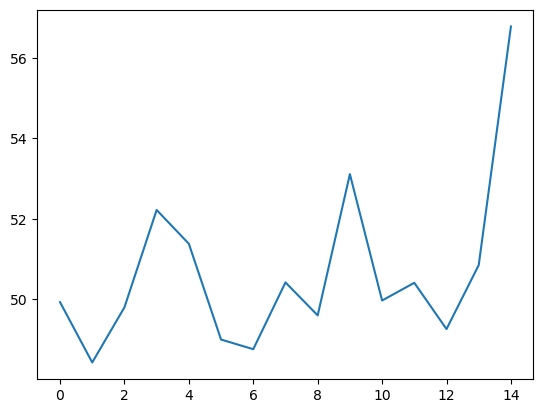

In [3]:
def percentage_buy_per_day(data):
    cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))
    
    nb_trades_expr = F.count("id").alias("nb_trades")
    pct_buy_expr = F.round(100 * cnt_cond(F.col("side") == "buy") / cnt_cond(F.col("side").isin(["buy", "sell"])), 2).alias("pct_buy")
    pct_buy = data.groupBy(F.col("date")).agg(nb_trades_expr, pct_buy_expr).sort("date")
    return pct_buy

pct_buy = percentage_buy_per_day(d)
pct_buy.show(1000)

nb_trades_per_day_list = utils.get_column_from_pyspark_df(pct_buy, "pct_buy", sort_column="date")
plt.plot(nb_trades_per_day_list)

In [41]:



# download_data("APTUSDT", date_types.DAILY, "2023-11-11", "2023-11-13")
# download_data("APTUSDT", date_types.MONTHLY, "2023-11", "2023-12")

Saved monthly data for APTUSDT during 2023-11 in /Users/martingangand/Documents/order_flow/data/monthly/APTUSDT/APTUSDT-trades-2023-11.csv
Saved monthly data for APTUSDT during 2023-12 in /Users/martingangand/Documents/order_flow/data/monthly/APTUSDT/APTUSDT-trades-2023-12.csv


In [40]:
from binance.client import Client


client = Client("api_key", "api_secret")
exchange_info = client.get_exchange_info()
nb = 0
for s in exchange_info["symbols"]:
    nb += 1
    if ("BTCU" in s["symbol"]):
        print(s["symbol"])
print(nb)

BTCUSDT
BTCUSDC
BTCUSDS
BTCUPUSDT
BTCUAH
BTCUSDP
BTCUST
WBTCUSDT
2444


In [69]:
symbol = "BTCUSDT"
start_date = "2023-11-17"
end_date = "2023-12-21"

data = data_loader.load_data(symbol, utils_dates.DateType.DAILY, start_date, end_date)
data.show(5, truncate=False)

AttributeError: 'NoneType' object has no attribute 'withColumnRenamed'

In [3]:
signs = utils.get_column_from_pyspark_df(data.filter(F.col("date") == "20231201"), "epsilon", "time")

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=23099Kb max_used=23199Kb free=107972Kb
 bounds [0x000000010a9e0000, 0x000000010c0b0000, 0x00000001129e0000]
 total_blobs=9231 nmethods=8302 adapters=840
 compilation: disabled (not enough contiguous free space left)


In [143]:
def replace_negative_values_with(values, replacement_value):
    for i in range(len(values)):
        if (values[i] < 0):
            values[i] = replacement_value
    return values

def K(l, gamma=2.1):
    assert(l >= 1)
    return l ** (-1.82)
    return l ** (-1.9989930197780839735268030209607060520490785301656013449251183795)
    return l ** (-2.1)
    # return l ** ((gamma - 3) / 2)

def plot_autocorrelation_convolution(x, nb_lags=None, color="blue", title="Autocorrelation plot", label="", mode="full", remove_negative_values=False, gamma=2.1, log_scale=True):
    fig, axe = plt.subplots(1, 1, figsize=(8, 4))
    autocorrelation = None
    if (nb_lags is None):
        autocorrelation = autocorrelation_calculator.autocorrelation_convolution(x, mode=mode)
    else:
        autocorrelation = autocorrelation_calculator.autocorrelation_convolution_perso(x, nb_lags)

    if (remove_negative_values):
        replace_negative_values_with(autocorrelation, np.nan)

    print(f"Autocorr: {autocorrelation[:10]}")
    axe.plot(autocorrelation, color, label=label)

    x = [i for i in range(1, len(autocorrelation))]
    y_1 = [f(l, gamma) for l in x]
    y_2 = [l ** (-0.5) for l in x]
    autocorrelation_coeffs = np.array([K(i) for i in range(2, 1000 + 2)])
    normalized_autocorrelation_coeffs = autocorrelation_coeffs / np.sum(autocorrelation_coeffs)

    axe.plot(x, y_1, "black", linestyle="dashed", label=f"l^((gamma - 3) / 2), gamma: {gamma}")
    axe.plot(x, y_2, "grey", linestyle="dashed", label="x^(-0.5)")
    axe.plot([i for i in range(1, 1000 + 1)], normalized_autocorrelation_coeffs, "orange", linestyle="dashed", label="K()")
    
    axe.legend()
    axe.set_title(title)
    axe.set_ylabel("Lags") 
    if (log_scale):
        axe.set_yscale("log")
    plt.grid(True)
    axe.set_xlim(-5, nb_lags)
    axe.set_ylim(np.nanmin(autocorrelation) - 0.1, np.nanmax(autocorrelation) + 0.1)
    plt.show()

def plot_autocorrelation_training_and_simulated_signs(training_signs, simulated_signs, nb_lags=None, mode="full"):
    fig, axe = plt.subplots(1, 2, figsize=(18, 4))
    autocorrelation_training, autocorrelation_simulated = None, None
    if (nb_lags is None):
        autocorrelation_training = autocorrelation_calculator.autocorrelation_convolution(training_signs, mode=mode)
        autocorrelation_simulated = autocorrelation_calculator.autocorrelation_convolution(simulated_signs, mode=mode)
    else:
        autocorrelation_training = autocorrelation_calculator.autocorrelation_convolution_perso(training_signs, nb_lags)
        autocorrelation_simulated = autocorrelation_calculator.autocorrelation_convolution_perso(simulated_signs, nb_lags)

    pacf_training = pacf(training_signs, nb_lags)
    pacf_simulated = pacf(simulated_signs, nb_lags)

    axe[0].plot(autocorrelation_training, "black", linestyle="dashed", label=f"Training signs ({len(training_signs)})")
    axe[0].plot(autocorrelation_simulated, "blue", label=f"Simulated signs ({len(simulated_signs)})")
    axe[0].plot(pacf_training, "grey", label=f"Training signs PACF ({len(simulated_signs)})")
    axe[0].plot(pacf_simulated, "red", label=f"Simulated signs PACF ({len(simulated_signs)})")
    axe[0].legend()
    axe[0].set_title("Autocorrelation plot for training and simulated signs (linear scale)")
    axe[0].set_ylabel("Lags")
    axe[0].set_xlim(-5, nb_lags)
    axe[0].set_ylim(min(np.nanmin(autocorrelation_training), np.nanmin(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) - 0.1, max(np.nanmax(autocorrelation_training), np.nanmax(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) + 0.1)
    axe[0].grid()

    axe[1].plot(autocorrelation_training, "black", linestyle="dashed", label=f"Training signs ({len(training_signs)})")
    axe[1].plot(autocorrelation_simulated, "blue", label=f"Simulated signs ({len(simulated_signs)})")
    axe[1].plot(pacf_training, "grey", label=f"Training signs PACF ({len(simulated_signs)})")
    axe[1].plot(pacf_simulated, "red", label=f"Simulated signs PACF ({len(simulated_signs)})")
    axe[1].legend()
    axe[1].set_title("Autocorrelation plot for training and simulated signs (log scale)")
    axe[1].set_ylabel("Lags")
    axe[1].set_yscale("log")
    axe[1].set_xlim(-5, nb_lags)
    axe[1].set_ylim(min(np.nanmin(autocorrelation_training), np.nanmin(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) - 0.1, max(np.nanmax(autocorrelation_training), np.nanmax(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) + 0.1)
    axe[1].grid()
  
    plt.show()

def plot_expected_value_details(values, title="Histogram", nb_bins=10):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].hist(values, bins=nb_bins, color='#0504aa', alpha=0.7, rwidth=0.85, density=True)
    axes[0].set_xlim(-1.2, 1.2)
    axes[0].set_xlabel("Expected value")
    axes[0].set_ylabel("Distribution")
    axes[0].set_title(title)

    axes[1].plot(values, color="orange")
    axes[1].set_ylim(-1.2, 1.2)
    axes[1].set_xlabel("Sign number")
    axes[1].set_ylabel("Expected value")
    axes[1].set_title("Expected value evolution")
    plt.show()
    
def f(l, gamma):
    return l ** ((gamma - 3) / 2)

/var/folders/wx/lmqsgmcd0m3dbfb_lc2gfg000000gn/T/ipykernel_87446/707436736.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe.set_ylim(0, np.nanmax(autocorrelation))


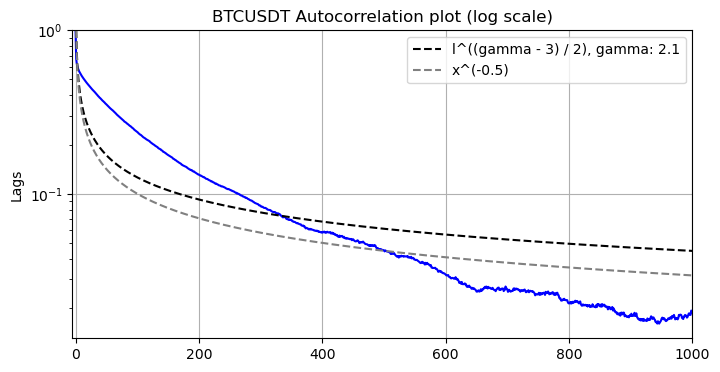

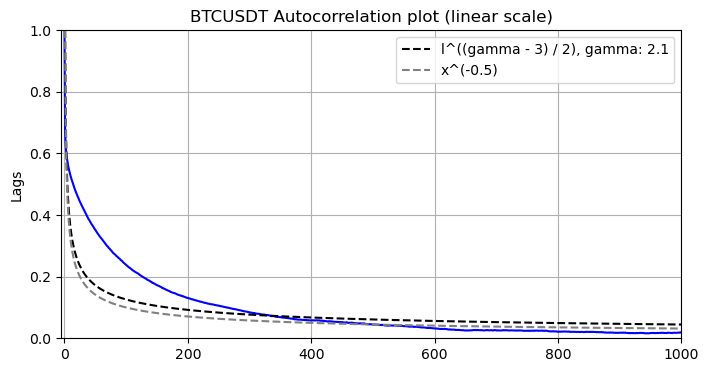

In [5]:
plot_autocorrelation_convolution(signs, 1000, 'blue', "BTCUSDT Autocorrelation plot (log scale)", gamma=2.1)
plot_autocorrelation_convolution(signs, 1000, 'blue', "BTCUSDT Autocorrelation plot (linear scale)", gamma=2.1, log_scale=False)

In [44]:
def print_buy_percentage_per_portion(signs, nb_portions):
    string = ""
    size_per_portion = len(signs) // nb_portions
    idx_start = 0
    idx_up = size_per_portion

    current_nb_portions = 0
    buy_percentages = []
    while (idx_start < len(signs)):
        current_nb_portions += 1
        current_portion_signs = signs[idx_start:idx_up]
        nb_buy = np.sum([1 if i == 1 else 0 for i in current_portion_signs])
        nb_sell = np.sum([1 if i == -1 else 0 for i in current_portion_signs])
        current_buy_percentage = 100 * nb_buy / (nb_buy + nb_sell)
        string += f"[{np.round(current_buy_percentage, 2)}" if string == "" else f" | {np.round(current_buy_percentage, 2)}"
        string += f"% ({len(current_portion_signs)})"
        idx_start = idx_up
        if (current_nb_portions == nb_portions - 1):
            idx_up = len(signs)
        else:
            idx_up += size_per_portion
        buy_percentages.append(current_buy_percentage)
        
    print(f"Portions of {size_per_portion} => {string}]")
    return buy_percentages

def print_signs_info(signs, step_name, nb_portions=10):
    print(f"========================== START ({step_name}, {len(signs)} signs) ==========================")
    nb_buy = np.sum([1 if i == 1 else 0 for i in signs])
    nb_sell = np.sum([1 if i == -1 else 0 for i in signs])
    print(f"Buy: {nb_buy} ({np.round(100 * nb_buy / (nb_buy + nb_sell), 3)}%) | Sell {nb_sell} ({np.round(100 * nb_sell / (nb_buy + nb_sell), 3)}%)")
    print_buy_percentage_per_portion(signs, nb_portions)
    print(f"========================== END ({step_name}, {len(signs)} signs) ==========================\n")

In [63]:
signs_test = signs[200000:600000] #[len(signs) // 2:]  [:500000]

Length => 300 | Sum => 0.950110682544384
========================== START (All training signs, 400000 signs) ==========================
Buy: 187161 (46.79%) | Sell 212839 (53.21%)
Portions of 40000 => [49.8% (40000) | 37.92% (40000) | 42.03% (40000) | 53.52% (40000) | 41.14% (40000) | 45.73% (40000) | 44.59% (40000) | 68.57% (40000) | 39.25% (40000) | 45.36% (40000)]
========================== END (All training signs, 400000 signs) ==========================

========================== START (Last training signs used for computing the expected value, 300 signs) ==========================
Buy: 107 (35.667%) | Sell 193 (64.333%)
Portions of 30 => [46.67% (30) | 46.67% (30) | 30.0% (30) | 0.0% (30) | 33.33% (30) | 56.67% (30) | 53.33% (30) | 33.33% (30) | 53.33% (30) | 3.33% (30)]
========================== END (Last training signs used for computing the expected value, 300 signs) ==========================

NB CAPPED: 62
========================== START (Generated signs, 400000 signs) ==

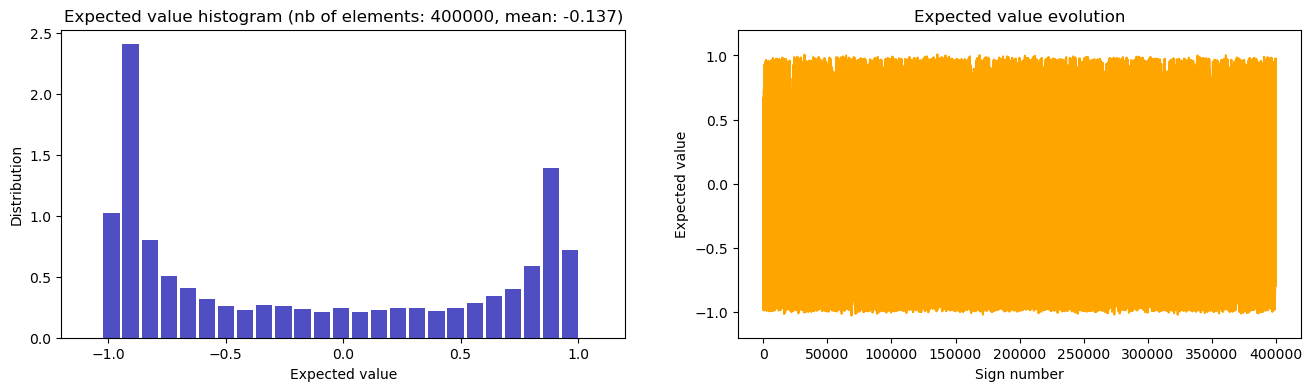

/var/folders/wx/lmqsgmcd0m3dbfb_lc2gfg000000gn/T/ipykernel_96168/3314001696.py:81: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe[1].set_ylim(min(np.nanmin(autocorrelation_training), np.nanmin(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) - 0.1, max(np.nanmax(autocorrelation_training), np.nanmax(autocorrelation_simulated), np.nanmin(pacf_training), np.nanmin(pacf_simulated)) + 0.1)


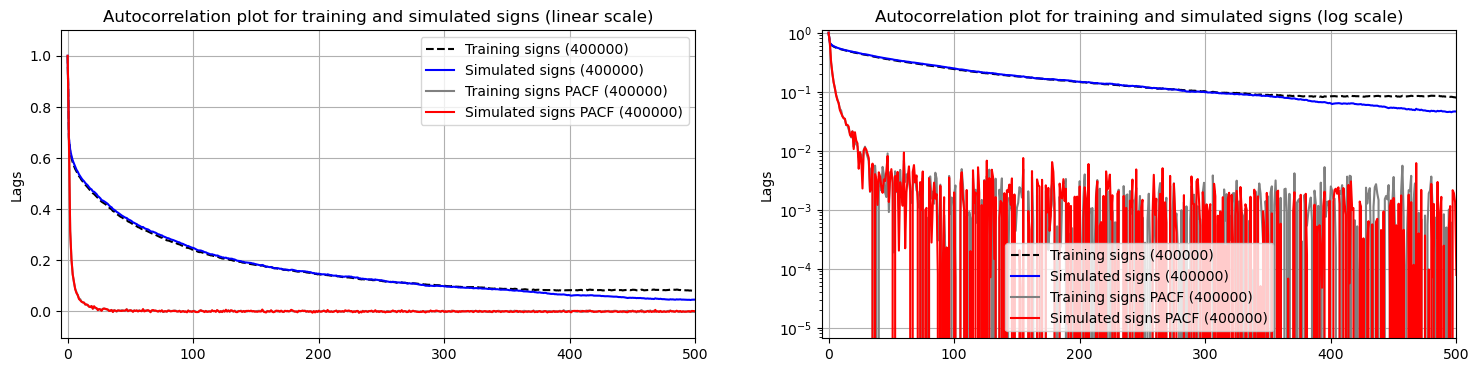

In [155]:
# V2
from statsmodels.tsa.ar_model import AutoReg

def generate_n_future_signs_V2(previous_signs, nb_future_signs, nb_lags, p):
    ar_model = AutoReg(signs_test, lags=nb_lags).fit()
    parameters = ar_model.params[1:]
    parameters_p = []
    for param in parameters:
        if (param >= 0):
            parameters_p.append(param)
    # parameters = parameters_p
    # parameters = np.array(parameters_p) / np.sum(parameters_p)
    print(f"Length => {len(parameters)} | Sum => {np.sum(parameters)}")

    print_signs_info(previous_signs, "All training signs")
    print_signs_info(previous_signs[-len(parameters):], "Last training signs used for computing the expected value")

    all_signs = previous_signs.copy()
    initial_len = len(previous_signs)
    expected_values = []
    simulated_signs = []
    capped = 0
    for _ in range(nb_future_signs):
        h = []
        expected_value = 0
        for i in range(len(parameters)):
            expected_value += (parameters[i] * all_signs[-i - 1])
            h.append(expected_value)
        expected_value = (2 * p - 1) * expected_value - 0.006
        expected_values.append(expected_value)
        
        proba_to_buy = (1 + expected_value) / 2
        if (not (proba_to_buy >= 0 and proba_to_buy <= 1)):
            capped += 1
            # print(expected_value, proba_to_buy, ar_model.params[0])
            # print(h)
            # print(parameters)
            # print(all_signs[-len(parameters):])
            if (proba_to_buy > 1):
                proba_to_buy = 1
            else:
                proba_to_buy = 0
        assert(proba_to_buy >= 0 and proba_to_buy <= 1)
        next_sign = 1 if np.random.uniform() <= proba_to_buy else -1
        all_signs.append(next_sign)
    simulated_signs = all_signs[initial_len:]
    print(f"NB CAPPED: {capped}")
    print_signs_info(simulated_signs, "Generated signs")
    
    # plt.plot(parameters, color="orange")
    # plt.xlabel("Lags")
    # plt.ylabel("Normalized coeffs")
    # plt.title("Normalized autocorrelation coeffs (linear scale)")

    plot_expected_value_details(expected_values, title=f"Expected value histogram (nb of elements: {len(expected_values)}, mean: {np.round(np.mean(expected_values), 3)})", nb_bins=25)
    plot_autocorrelation_training_and_simulated_signs(previous_signs, simulated_signs, 500)
    # plot_autocorrelation_convolution(previous_signs, 1000, title="Autocorrelation plot (training signs) | Log scale")
    # plot_autocorrelation_convolution(previous_signs, 1000, title="Autocorrelation plot (training signs) | Linear scale", log_scale=False)
    # plot_autocorrelation_convolution(simulated_signs, 1000, title="Autocorrelation plot (generated signs) | Log scale")
    # plot_autocorrelation_convolution(simulated_signs, 1000, title="Autocorrelation plot (generated signs) | Linear scale", log_scale=False)
    return simulated_signs

importlib.reload(autocorrelation_calculator)

nb_future_signs = len(signs_test)
nb_lags = 300
p = 1
future_signs = generate_n_future_signs_V2(signs_test, nb_future_signs, nb_lags, p)

400000
200000
Portions of 1000 => [76.1% (1000) | 49.1% (1000) | 28.2% (1000) | 24.0% (1000) | 75.8% (1000) | 31.1% (1000) | 26.6% (1000) | 37.7% (1000) | 32.3% (1000) | 60.7% (1000) | 48.6% (1000) | 56.8% (1000) | 48.8% (1000) | 66.8% (1000) | 97.6% (1000) | 75.3% (1000) | 45.1% (1000) | 47.4% (1000) | 70.1% (1000) | 86.3% (1000) | 36.6% (1000) | 27.1% (1000) | 27.0% (1000) | 22.7% (1000) | 39.8% (1000) | 71.4% (1000) | 49.2% (1000) | 62.5% (1000) | 64.1% (1000) | 48.7% (1000) | 37.5% (1000) | 58.5% (1000) | 41.1% (1000) | 59.8% (1000) | 82.2% (1000) | 39.3% (1000) | 17.8% (1000) | 57.9% (1000) | 26.8% (1000) | 37.8% (1000) | 16.6% (1000) | 40.2% (1000) | 16.3% (1000) | 65.8% (1000) | 35.2% (1000) | 20.4% (1000) | 53.7% (1000) | 41.0% (1000) | 38.1% (1000) | 59.5% (1000) | 33.6% (1000) | 60.3% (1000) | 55.6% (1000) | 55.4% (1000) | 16.6% (1000) | 36.6% (1000) | 6.1% (1000) | 8.2% (1000) | 35.2% (1000) | 7.1% (1000) | 9.9% (1000) | 59.6% (1000) | 25.5% (1000) | 36.4% (1000) | 25.8% (10

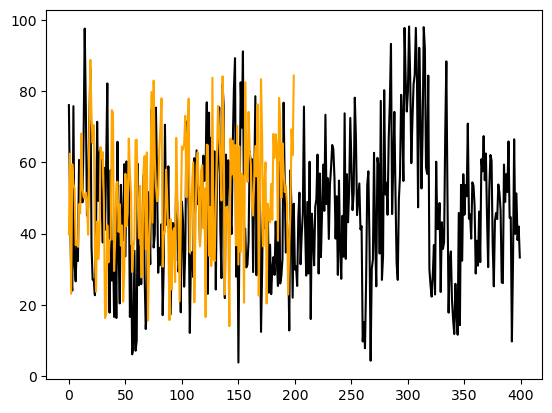

In [104]:
nb_signs_per_portions = 1000
print(len(signs_test))
print(len(future_signs))
plt.plot(print_buy_percentage_per_portion(signs_test, int(len(signs_test) / nb_signs_per_portions)), "black")
plt.plot(print_buy_percentage_per_portion(future_signs, int(len(future_signs) / nb_signs_per_portions)), "orange")
print(np.mean(print_buy_percentage_per_portion(signs_test, int(len(signs_test) / nb_signs_per_portions))))
print(np.var(print_buy_percentage_per_portion(signs_test, int(len(signs_test) / nb_signs_per_portions))))

print(np.mean(print_buy_percentage_per_portion(future_signs, int(len(future_signs) / nb_signs_per_portions))))
print(np.var(print_buy_percentage_per_portion(future_signs, int(len(future_signs) / nb_signs_per_portions))))


In [6]:
from statsmodels.tsa.stattools import adfuller
signs_test = signs[:100000]
df_stationarityTest = adfuller(signs_test, autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])

P-value:  0.0


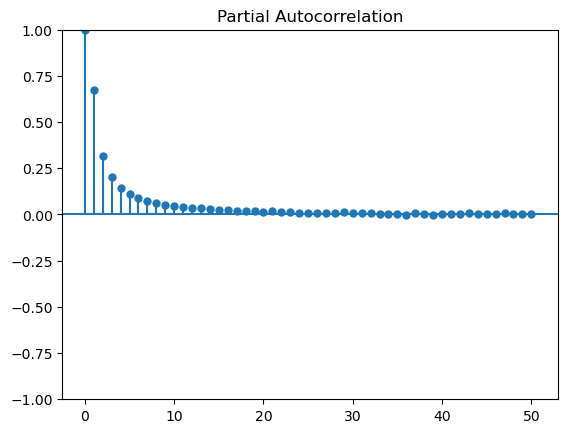

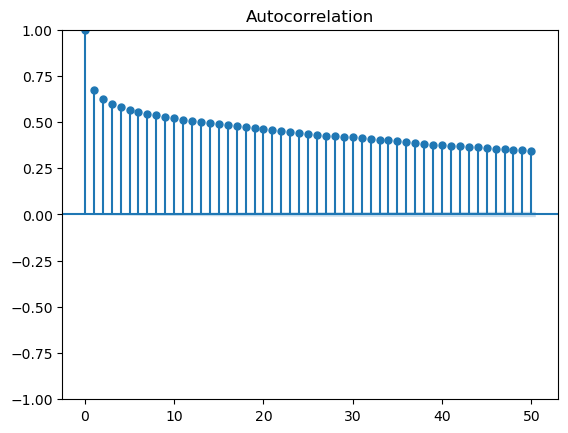

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf = plot_pacf(signs_test, lags=50)
acf = plot_acf(signs_test, lags=50)

In [100]:
from statsmodels.tsa.ar_model import AutoReg
ar_model = AutoReg(signs_test, lags=125).fit()
#
# Print Summary
#
# print(ar_model.summary())
coeffs = ar_model.params[1:]
print(len(coeffs), sum(coeffs))
print(coeffs[:10])
# plt.plot(coeffs)


125 0.9441001437863615
[0.31204807 0.14108772 0.08984722 0.06251513 0.04792222 0.03515184
 0.03077804 0.02621214 0.01825998 0.02001144]


In [101]:
print(sum(ar_model.bse))

0.21141314609300924


0.8705
-0.7815999999999999
========================== START (, 500000 signs) ==========================
Buy: 236878 (47.376%) | Sell 263122 (52.624%)
Portions of 50000 => [52.18% (50000) | 49.06% (50000) | 47.52% (50000) | 48.35% (50000) | 47.58% (50000) | 37.95% (50000) | 51.63% (50000) | 42.36% (50000) | 46.05% (50000) | 51.07% (50000)]
========================== END (, 500000 signs) ==========================

-0.05254363430816333


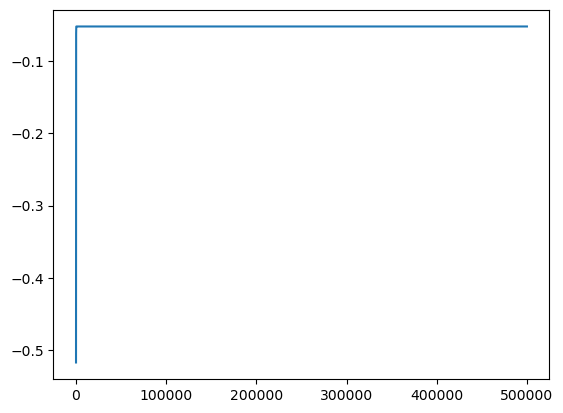

In [53]:
a = [0.2690, 0.1425, 0.0964, 0.0758, 0.0553, 0.0512, 0.0571, 0.0334, 0.0394, 0.0504]
b = [1.0363, 1.0402,1.0402, 0.4044,0.4044, -0.4457, -0.4457, -1.1777 , -1.1777 , -1.4603]
print(sum(a))
print(sum(b))
pred = ar_model.predict(start=len(signs_test), end=len(signs_test) * 2, dynamic=False)
print_signs_info(signs_test, "")
plt.plot(pred)
print(pred[1000])

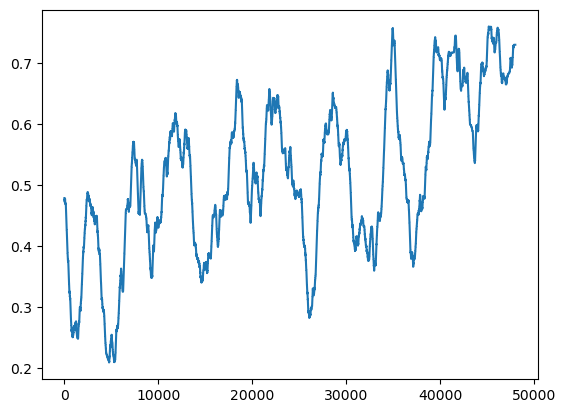

In [37]:
values = []
def percentage_buy(signs):
    return np.sum([1 for sign in signs if sign == 1]) / len(signs)

l = 2000
for i in range(l, len(signs_test)):
    values.append(percentage_buy(signs_test[i-l:i]))
    # values.append(np.mean(signs_test[i-l:i]))
plt.plot(values)

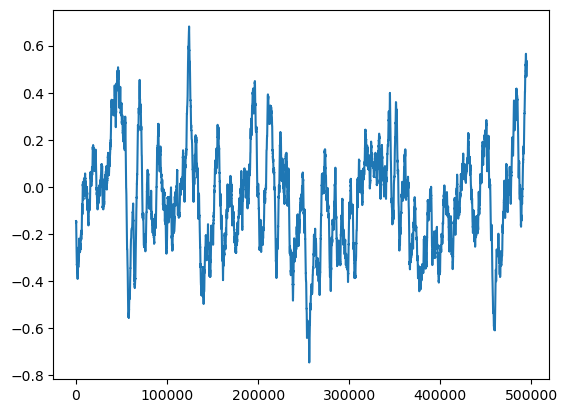

In [42]:
signs_test = signs[:500000]
values = []
l = 5000
for i in range(l, len(signs_test)):
    values.append(np.mean(signs_test[i-l:i]))
plt.plot(values)

In [119]:
def autocorrelation_statistical(x, length=20):
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])
print(autocorrelation_statistical(signs_test))

[1.         0.59084605 0.53501419 0.46604099 0.49977718 0.48305675
 0.50498983 0.45317801 0.41039251 0.40268901 0.38569504 0.40761022
 0.35510937 0.35838048 0.34119561 0.35381085 0.34125136 0.33510839
 0.29424418 0.30212177]


The Autocorrelation plot for the data is:


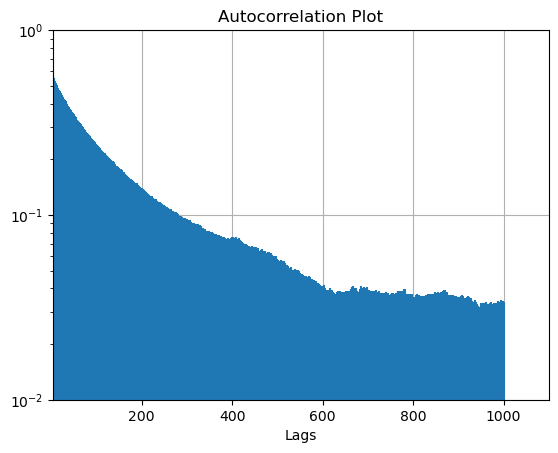

In [21]:
# Adding plot title.
plt.title("Autocorrelation Plot") 
 
# Providing x-axis name.
plt.xlabel("Lags") 
 
# Plotting the Autocorrelation plot.
plt.acorr(signs[:500001], maxlags = 1000) 
 
# Displaying the plot.
print("The Autocorrelation plot for the data is:")
plt.yscale("log")
plt.grid(True)
plt.xlim(left=4)
plt.ylim(0.01, 1)
plt.show()

In [ ]:
def order_sign_imbalance(signs):
    return np.sum(signs) / len(signs)